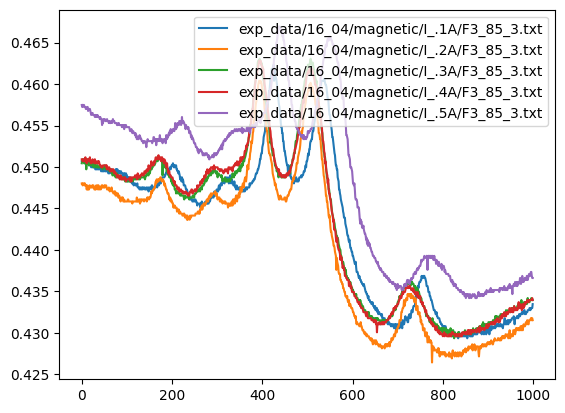

In [200]:
# Collate all the data from exp_data/16_04 and plot the first files for all the different magnetic data
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Define the directory containing the data
data_dir = "exp_data/16_04/magnetic"

# Initialize a dictionary to store data
data_dict = {}

# Iterate through the files in the directory
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path, sep="\t", header=0)
            data_dict[file_path] = data

for file_name, data in data_dict.items():
    if file_name.endswith("_1.txt"):
        # plt.plot(data[0], data[1], label=file_name)
        break  # Only plot the first file

for i in range(1, 6):
    file_name = f"exp_data/16_04/magnetic/I_.{i}A/F3_85_3.txt"
    if file_name in data_dict:
        df = data_dict[file_name]
        plt.plot(df["Main in [V]"], label=file_name)
plt.legend()
plt.show()

In [201]:
x = np.linspace(0, 1000, 1000)

/var/folders/cs/t7hq7xj94n13sr47pvj399n00000gn/T/ipykernel_54985/3528717766.py:56: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for legend


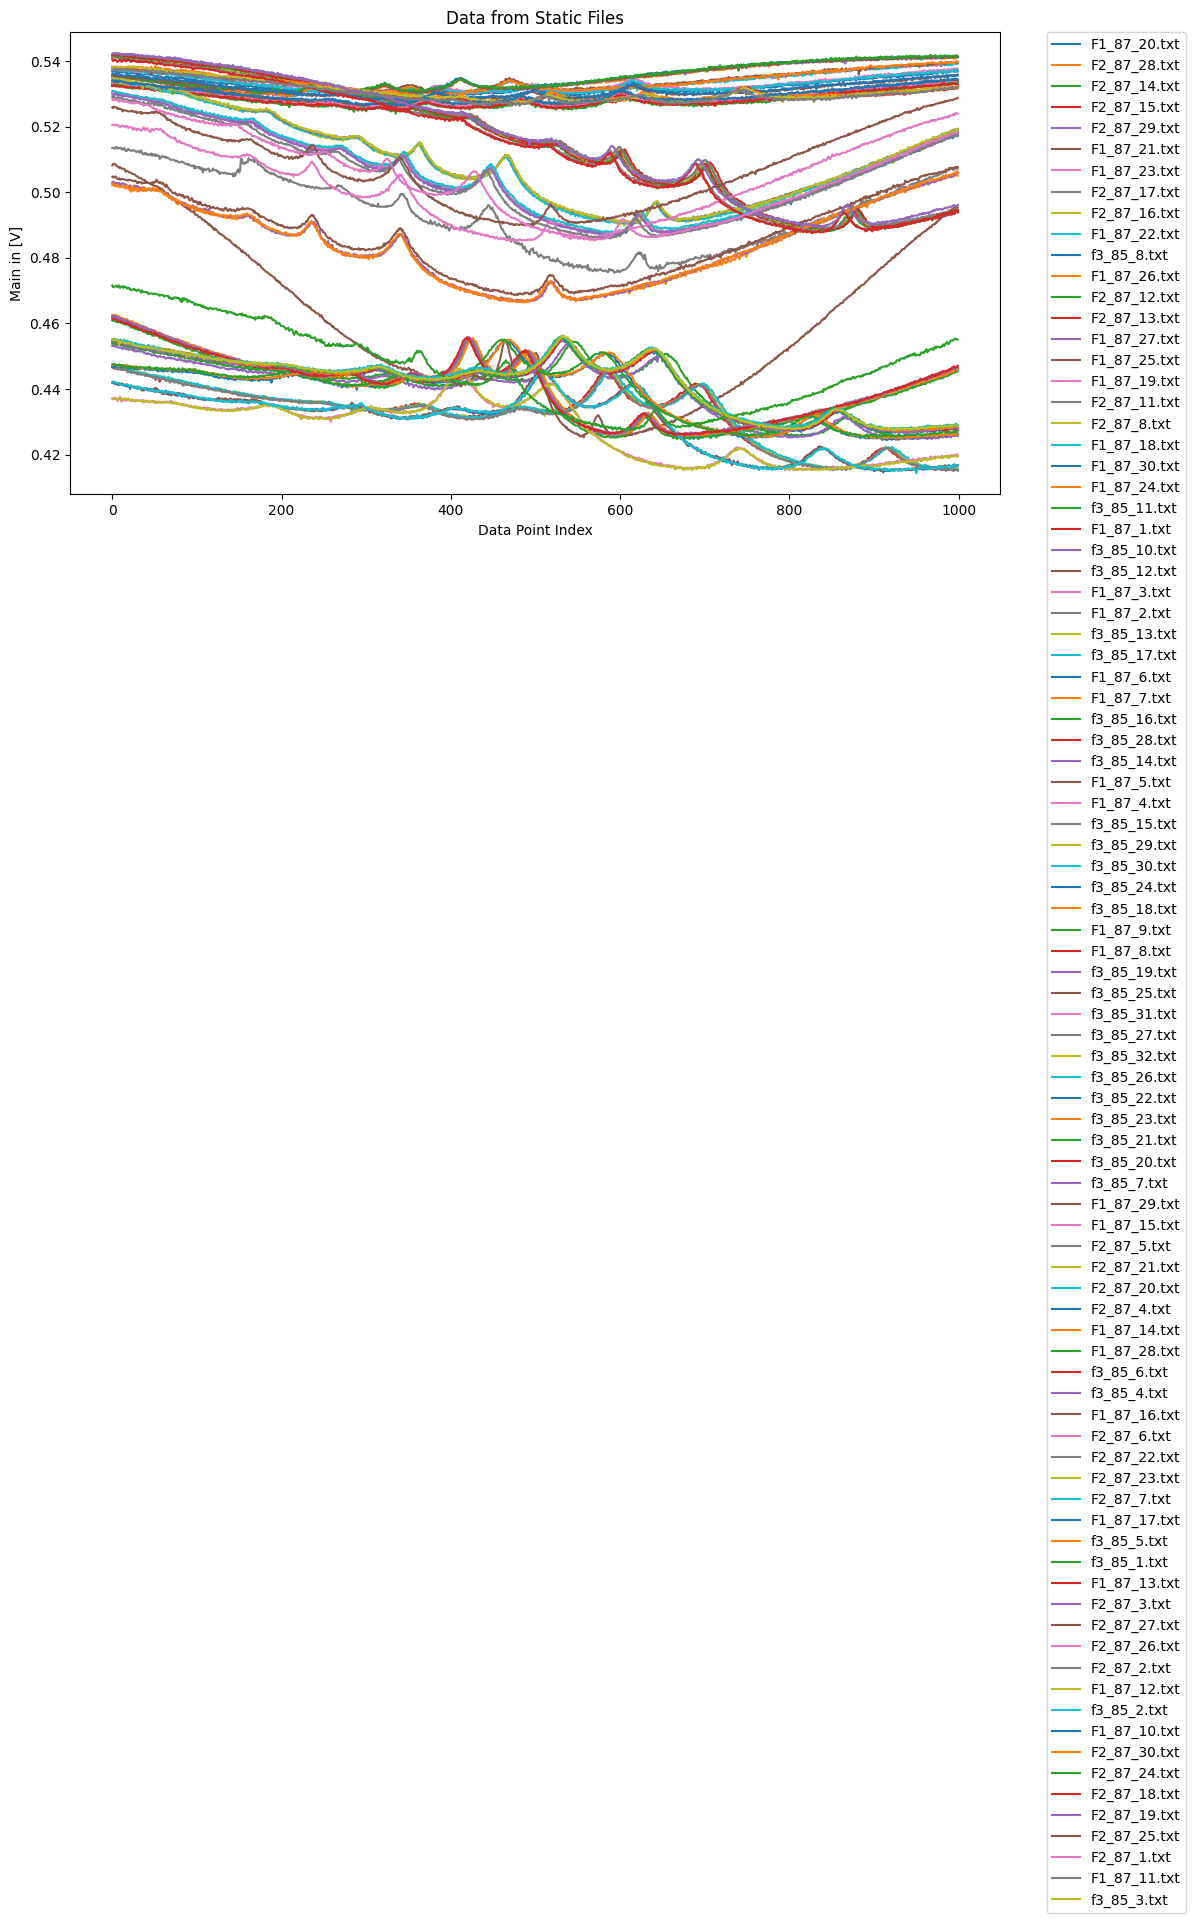

In [202]:
# Generate synthetic static data for each type in exp_data/16_04/static
import glob

# Identify unique data types by filename prefixes
static_data_dir = "exp_data/16_04/static"
files = glob.glob(os.path.join(static_data_dir, "*.txt"))

prefixes = set()
for f in files:
    basename = os.path.basename(f)
    # Remove extension
    name_part = os.path.splitext(basename)[0]
    # Extract prefix (part before the last underscore, if any)
    prefix = name_part.rsplit("_", 1)[0] if "_" in name_part else name_part
    prefixes.add(prefix)

# for each type of data, generate synthetic data
{"F1_87": 2, "F2_87": 3, "f3_85": 4}

# parametrise the data for each file

# file_name:

# plot data for all the static files
plt.figure(
    figsize=(12, 6)
)  # Optional: Adjust figure size for better readability if many files

for file_path in files:
    try:
        # Read the data from the static file
        static_data = pd.read_csv(file_path, sep="\t", header=0)
        # Plot the 'Main in [V]' column (assuming this column exists and is relevant)
        # If a different column should be plotted, change 'Main in [V]' accordingly.
        # If an x-axis column exists (e.g., time or index), use it: plt.plot(static_data['X_COLUMN'], static_data['Main in [V]'], ...)
        plt.plot(static_data["Main in [V]"], label=os.path.basename(file_path))
    except FileNotFoundError:
        print(f"Warning: File not found {file_path}")
    except pd.errors.EmptyDataError:
        print(f"Warning: File is empty {file_path}")
    except KeyError:
        print(f"Warning: Column 'Main in [V]' not found in {file_path}")
    except Exception as e:
        print(f"Could not process file {file_path}: {e}")

# Add plot title and labels
plt.title("Data from Static Files")
plt.xlabel("Data Point Index")
plt.ylabel("Main in [V]")  # Adjust ylabel if plotting a different column

# Add a legend (might be crowded if there are many files)
# Consider plotting only a subset or using different colors/styles if needed
plt.legend(
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0
)  # Place legend outside plot
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for legend
plt.show()

In [203]:
import scipy as sp
# plot one file from thje static data


def gaussian(x, amp, mean, stddev, offset):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev**2)) + offset


def constrained_gaussian_with_offset(x, mu, sigma, C, x0, y0):
    exponent = ((x0 - mu) ** 2 - (x - mu) ** 2) / (2 * sigma**2)
    return (y0 - C) * np.exp(exponent) + C


def rescale_data(data):
    """Rescales a numpy array to the range [0, 1]."""
    min_val = np.min(data)
    max_val = np.max(data)
    range_val = max_val - min_val
    if range_val == 0:
        return np.zeros_like(data)
    else:
        return (data - min_val) / range_val


def fit_gaussian_with_interpolation(file_path, gap=100):
    """
    Rescales y_data, interpolates a gap quadratically, fits a Gaussian model.

    Args:
        x_data (np.ndarray): The x-coordinates of the data points.
        y_data (np.ndarray): The y-coordinates of the data points.
        gap (int): The size of the gap at the beginning and end to exclude
                   from direct fitting and use for interpolation points.

    Returns:
        tuple: A tuple containing:
            - popt (np.ndarray): Optimal values for the Gaussian parameters
                                 (amp, mean, stddev, offset).
            - pcov (np.ndarray): The estimated covariance of popt.
            - y_data_fit (np.ndarray): The y_data array used for fitting,
                                       with the gap interpolated.
    """
    static_data = pd.read_csv(file_path, sep="\t", header=0)

    x_data = np.arange(len(static_data["Main in [V]"]))
    y_data = static_data["Main in [V]"].values

    # Rescale y_data to [0, 1]
    y_data_rescaled = rescale_data(y_data)

    # Define indices for the interpolation points (start-1, midpoint, end-1 of the gap)
    idx_p1 = gap - 1  # Index before the start of the middle section
    idx_p3 = len(x_data) - gap  # Index at the start of the end section
    idx_p2 = np.argmin(y_data_rescaled)  # Index of the minimum value
    # Ensure indices are valid
    if not (
        0 <= idx_p1 < len(x_data)
        and 0 <= idx_p3 < len(x_data)
        and 0 <= idx_p2 < len(x_data)
    ):
        raise ValueError("Gap size is too large for the given data length.")
    if idx_p1 >= idx_p3:
        raise ValueError(
            "Gap size results in overlapping or invalid interpolation points."
        )

    # Get the x and y values for the three points needed for quadratic interpolation
    # Using points just before the gap, the last point, and the first point after the gap
    x_interp = x_data[[idx_p1, idx_p2, idx_p3]]
    y_interp = y_data_rescaled[[idx_p1, idx_p2, idx_p3]]

    # Create the quadratic interpolation function using scipy.interpolate.interp1d
    # Use points surrounding the gap for interpolation
    f_quad = sp.interpolate.interp1d(
        x_interp, y_interp, kind="linear", bounds_error=False, fill_value="extrapolate"
    )

    # Define the x values for the section to be interpolated
    x_middle = x_data[gap:-gap]
    if len(x_middle) == 0:
        raise ValueError("Gap size is too large, leaving no middle section.")

    y_interpolated = f_quad(x_middle)

    # Construct the y_data_fit array by concatenating the parts:
    # First `gap` points, interpolated middle points, Last `gap` points
    y_data_fit = np.concatenate(
        (y_data_rescaled[:gap], y_interpolated, y_data_rescaled[-gap:])
    )

    # Ensure y_data_fit has the same length as x_data
    if len(y_data_fit) != len(x_data):
        # This might happen if gap calculation leads to off-by-one, adjust logic if necessary
        # For now, let's raise an error or handle based on specific needs.
        # A simple fix might be adjusting the slice indices slightly, but requires care.
        # Let's try adjusting the middle section calculation slightly if lengths mismatch
        num_middle_points = len(x_data) - 2 * gap
        x_middle = x_data[gap : gap + num_middle_points]
        y_interpolated = f_quad(x_middle)
        y_data_fit = np.concatenate(
            (y_data_rescaled[:gap], y_interpolated, y_data_rescaled[-gap:])
        )

        # Final check
        if len(y_data_fit) != len(x_data):
            raise ValueError(
                f"Constructed y_data_fit length ({len(y_data_fit)}) does not match x_data length ({len(x_data)}). Check gap and slicing logic."
            )

    # Fit the Gaussian model to the data
    # Provide reasonable initial guesses and bounds if possible
    # initial_guess = [-np.ptp(y_data_fit), np.mean(x_data), np.std(x_data), np.min(y_data_fit)]
    bounds = (
        [-np.inf, -np.inf, 0, -np.inf],
        [0, np.inf, np.inf, np.inf],
    )  # Assuming negative amplitude, stddev > 0
    sigma = np.ones_like(y_data_fit)
    sigma[[0, gap, idx_p2, -gap, -1]] = 0.01
    try:
        popt, pcov = curve_fit(
            gaussian,
            x_data,
            y_data_fit,
            p0=[-1, np.mean(x_data), np.std(x_data), np.min(y_data_fit)],
            bounds=bounds,
            sigma=sigma,
        )
    except RuntimeError as e:
        print(f"Curve fitting failed: {e}")
        # Fallback or re-attempt with different parameters if needed
        # Trying without bounds as a fallback
        try:
            print("Retrying fit without bounds...")
            popt, pcov = curve_fit(
                lambda x, mu, sigma, C: constrained_gaussian_with_offset(
                    x, mu, sigma, C, idx_p2, np.min(y_data_fit)
                ),
                x_data,
                y_data,
                p0=[0, 1, 0],
            )
        except Exception as e2:
            print(f"Curve fitting failed on retry: {e2}")
            popt, pcov = None, None  # Indicate failure

    return popt, pcov, y_data_fit

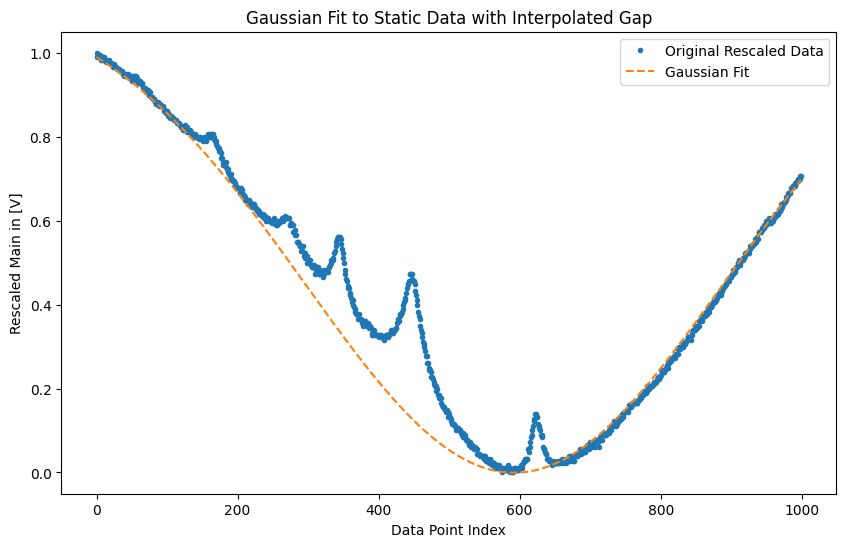

Fitted Gaussian Parameters (amp, mean, stddev, offset):
[ -1.14778035 592.27553099 297.25670274   1.14718493]


In [204]:
file_path = "exp_data/16_04/static/F2_87_6.txt"  # Example file path

# Assuming the file exists and is in the correct format
# Call the function
popt, pcov, y_fit = fit_gaussian_with_interpolation(file_path=file_path, gap=100)
x_data = np.arange(1000)
y_data = pd.read_csv(file_path, sep="\t", header=0)["Main in [V]"].values
y_data_rescaled = rescale_data(y_data)
# Plot the results if fitting was successful
if popt is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, rescale_data(y_data), ".", label="Original Rescaled Data")
    # plt.plot(x_data, y_fit, "-", label="Interpolated Data for Fit")
    plt.plot(x_data, gaussian(x_data, *popt), "--", label="Gaussian Fit")
    plt.title("Gaussian Fit to Static Data with Interpolated Gap")
    plt.xlabel("Data Point Index")
    plt.ylabel("Rescaled Main in [V]")
    plt.legend()
    plt.show()

    print("Fitted Gaussian Parameters (amp, mean, stddev, offset):")
    print(popt)

else:
    print("Could not fit Gaussian model.")
    # Optionally plot the original and interpolated data even if fit failed
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, rescale_data(y_data), ".", label="Original Rescaled Data")
    # plt.plot(x_data, y_fit, "-", label="Interpolated Data")
    plt.title("Static Data with Interpolated Gap (Fit Failed)")
    plt.xlabel("Data Point Index")
    plt.ylabel("Rescaled Main in [V]")
    plt.legend()
    plt.show()

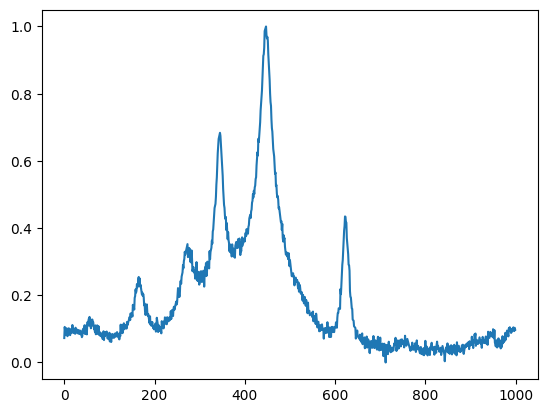

In [205]:
y_clean = y_data_rescaled - gaussian(x_data, *popt)
y_clean = rescale_data(y_clean)
plt.plot(x_data, y_clean, label="Cleaned Data")

[[Model]]
    ((((Model(lorentzian, prefix='lz1_') + Model(lorentzian, prefix='lz2_')) + Model(lorentzian, prefix='lz3_')) + Model(lorentzian, prefix='lz4_')) + Model(lorentzian, prefix='lz5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32000
    # data points      = 1000
    # variables        = 15
    chi-square         = 2.45622889
    reduced chi-square = 0.00249363
    Akaike info crit   = -5979.12808
    Bayesian info crit = -5905.51175
    R-squared          = 0.92827068
##  Warning: uncertainties could not be estimated:
    lz1_sigma:      at boundary
    lz4_sigma:      at boundary
[[Variables]]
    lz1_amplitude:  22.9723440 (init = 1)
    lz1_center:     160.415115 (init = 142.7143)
    lz1_sigma:      50.0000000 (init = 0.05)
    lz1_fwhm:      100.0000000 == '2.0000000*lz1_sigma'
    lz1_height:     0.14624649 == '0.3183099*lz1_amplitude/max(1e-15, lz1_sigma)'
    lz2_amplitude:  66.1739844 (init = 1)
    lz2_center:     340.399240 (init 

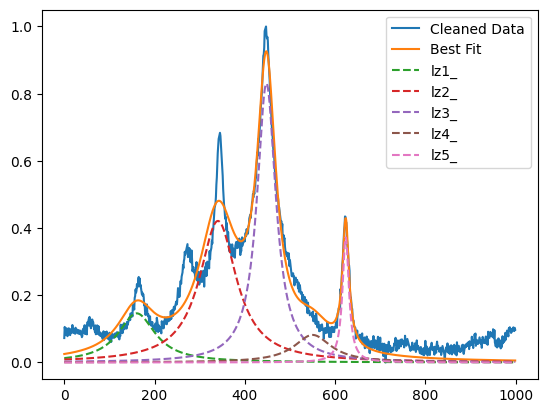

In [206]:
# fit 6 Lorentzian peaks to cleaned data using LMFit
from lmfit.models import LorentzianModel


# helper to create a Lorentzian component
def add_peak(prefix, center, amplitude=1.0, sigma=0.05):
    peak = LorentzianModel(prefix=prefix)
    pars = peak.make_params()
    pars[prefix + "center"].set(center)
    pars[prefix + "amplitude"].set(amplitude, min=0.1)
    pars[prefix + "sigma"].set(sigma, min=0, max=50)
    return peak, pars


# initialize composite model and params
model = None
params = None
# define six rough peak centers across data range
centers = np.linspace(np.min(x_data), np.max(x_data), 8)[1:-1][:5]
for i, cen in enumerate(centers):
    peak, pars = add_peak(f"lz{i+1}_", cen)
    if model is None:
        model = peak
        params = pars
    else:
        model += peak
        params.update(pars)
# perform the fitting
result = model.fit(y_clean, params, x=x_data)
# report and plot
print(result.fit_report())
components = result.eval_components(x=x_data)
plt.figure()
plt.plot(x_data, y_clean, label="Cleaned Data")
plt.plot(x_data, result.best_fit, label="Best Fit")
for name, comp in components.items():
    plt.plot(x_data, comp, "--", label=name)
plt.legend()

# doesnt work at the moment